In [5]:
from sklearn.datasets import load_iris
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import time
import numpy as np
import pandas as pd

iris = load_iris() # 加载Iris数据集
X = iris.data  # 特征数据

In [19]:
# 定义不同的参数组合
param_combinations = [
    (n, affinity, linkage)
    for n in [3, 5, 7, 10]  # 不同的n_clusters值
    for affinity in ['euclidean', 'manhattan', 'cosine'] # 不同的affinity度量
    for linkage in ['ward', 'complete', 'average', 'single'] # 不同的linkage策略
    if not (affinity != 'euclidean' and linkage == 'ward')  # 排除不兼容的组合
]

results = []

In [20]:
# 对于每组参数，运行 AgglomerativeClustering 并记录结果
for n_clusters, affinity, linkage in param_combinations:
    
    start_time = time.time()
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity=affinity, linkage=linkage)
    
    labels = clusterer.fit_predict(X)
    end_time = time.time()
    
    # 计算轮廓系数
    score = silhouette_score(X, labels)
    
    # 记录结果
    results.append({
        'n_clusters': n_clusters,
        'affinity': affinity,
        'linkage': linkage,
        'runtime': end_time - start_time,
        'silhouette_score': score
    })

# 打印结果
for result in results:
    print(f"n_clusters: {result['n_clusters']}, Affinity: {result['affinity']}, Linkage: {result['linkage']}, Runtime: {result['runtime']:.4f}s, Silhouette Score: {result['silhouette_score']:.4f}")

n_clusters: 3, Affinity: euclidean, Linkage: ward, Runtime: 0.0010s, Silhouette Score: 0.5543
n_clusters: 3, Affinity: euclidean, Linkage: complete, Runtime: 0.0020s, Silhouette Score: 0.5136
n_clusters: 3, Affinity: euclidean, Linkage: average, Runtime: 0.0010s, Silhouette Score: 0.5542
n_clusters: 3, Affinity: euclidean, Linkage: single, Runtime: 0.0006s, Silhouette Score: 0.5121
n_clusters: 3, Affinity: manhattan, Linkage: complete, Runtime: 0.0000s, Silhouette Score: 0.5544
n_clusters: 3, Affinity: manhattan, Linkage: average, Runtime: 0.0000s, Silhouette Score: 0.5535
n_clusters: 3, Affinity: manhattan, Linkage: single, Runtime: 0.0000s, Silhouette Score: 0.3403
n_clusters: 3, Affinity: cosine, Linkage: complete, Runtime: 0.0000s, Silhouette Score: 0.3996
n_clusters: 3, Affinity: cosine, Linkage: average, Runtime: 0.0000s, Silhouette Score: 0.5538
n_clusters: 3, Affinity: cosine, Linkage: single, Runtime: 0.0000s, Silhouette Score: 0.5538
n_clusters: 5, Affinity: euclidean, Linkag

In [15]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import heapq

# 初始化链接矩阵和距离矩阵
def linkage_matrix_init(X):

    # 计算所有样本点之间的欧几里得距离
    dist_matrix = squareform(pdist(X, 'euclidean'))
    
    # 初始化链接矩阵，用于记录每一步聚类合并的信息
    linkage_matrix = np.zeros((len(X) - 1, 4))
    return dist_matrix, linkage_matrix

# 使用最小堆找到距离最近的两个聚类
def find_clusters_to_merge(heap, cluster_indices):

    while heap:
        dist, i, j = heapq.heappop(heap)
        if i in cluster_indices and j in cluster_indices and i != j:
            return (i, j), dist
    return (None, None), np.inf

def agglomerative_clustering(X, n_clusters):
    n_samples = X.shape[0]
    dist_matrix, linkage_matrix = linkage_matrix_init(X)
    cluster_indices = {i: {i} for i in range(n_samples)}

    # 初始化最小堆
    heap = []
    for i in range(n_samples):
        for j in range(i + 1, n_samples):
            heapq.heappush(heap, (dist_matrix[i, j], i, j))

    for step in range(n_samples - n_clusters):
        # 找到要合并的两个聚类
        (i, j), dist = find_clusters_to_merge(heap, cluster_indices)

        # 合并聚类
        new_cluster = cluster_indices[i].union(cluster_indices[j])
        new_index = n_samples + step

        # 更新链接矩阵
        linkage_matrix[step, 0] = i
        linkage_matrix[step, 1] = j
        linkage_matrix[step, 2] = dist
        linkage_matrix[step, 3] = len(new_cluster)

        # 更新聚类索引
        del cluster_indices[i], cluster_indices[j]
        cluster_indices[new_index] = new_cluster

        # 更新堆中的距离
        for k in cluster_indices.keys():
            if k != new_index:
                new_dist = np.mean(dist_matrix[np.ix_(list(new_cluster), list(cluster_indices[k]))])
                heapq.heappush(heap, (new_dist, new_index, k))
    
    # 生成最终的聚类标签
    cluster_labels = np.zeros(n_samples, dtype=int)
    for label, indices in cluster_indices.items():
        for index in indices:
            cluster_labels[index] = label

    return cluster_labels, linkage_matrix

# 示例
from sklearn.datasets import load_iris
from sklearn.metrics import silhouette_score

iris = load_iris()
X = iris.data

# 执行聚类
labels, matrix = agglomerative_clustering(X, 5)

# 评估聚类结果
score = silhouette_score(X, labels)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.4307


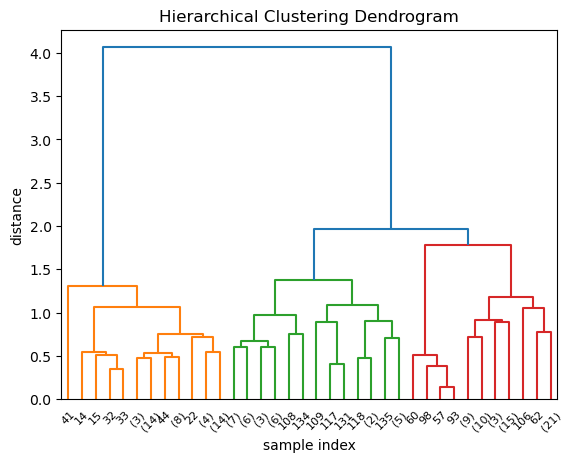

In [38]:
import scipy.cluster.hierarchy as sch
dist_matrix = sch.distance.pdist(X,'euclidean')
Z = sch.linkage(dist_matrix, method='average', metric='euclidean')

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
P = sch.dendrogram(Z, truncate_mode='level', p=5, color_threshold=1.8) 
#truncate_mode指定截取模式，p为要显示的截取高度（y轴的阈值）

plt.savefig('plot_dendrogram.png') 
#将层次聚类结果以树状图表示并保存
plt.show()
